# [CUDA] 🚀 Accelerating Mandelbrot fractal with GPU
*** 
**Jérémy Lesuffleur - 13/03/2021**

## Table of contents

* [Introduction to the Mandelbrot set](#introduction)

* [Part 1: Computation on **CPU** with NumPy](#part1)

* [Part 2: Computation on **GPU** with CUDA](#part2)



# Introduction to the Mandelbrot set
<a id="introduction"></a>
***

In this notebook we will see how to plot the [Mandelbrot Set](https://en.wikipedia.org/wiki/Mandelbrot_set). We will begin with a standart implementation with numpy using only CPU. Then we will speed up things using GPU with CUDA. 

### Definition of the Mandelbrot set

The Mandelbrot set is the **set of complex numbers $c$ such that the following sequence is bounded:**

$$\begin{equation}
    \begin{cases}
        z_0=0\\
        z_{n+1}=z_n^2+c
    \end{cases} 
\end{equation}$$

The beauty of the Mandelbrot set is that such a simple equation leads to a *chaotic* set. Such figures are called [fractals](https://en.wikipedia.org/wiki/Fractal).

To **draw the set**, we will map each pixel of a 2D image to a complex number $c$, and compute the sequence $z_n$ by iteration. We can prove that if $|z_n| > 2$ for any $n$, then the sequence is unbounded. Using this property, we can stop the iteration once this criteria is met. The number of iteration before meeting the criteria is kept, and will be used to color the space outside of the set.

The Mandelbrot set is a very good candidate for GPU computing. Indeed, the computation of pixels being independent from each other, it is easy to parallelize them on the GPU threads.


# Part 1: Computation on CPU with NumPy
<a id="part1"></a>
***

For this first part, we will use mainly `numpy` to compute the set, and `matplotlib` to render it:

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

We define the `mandel` function that returns the Mandelbrot set as a 2D NumPy array. Our function will take the following parameters:

- `xmin, xmax, ymin, ymax`: coordonates of the frame in which we compute the Mandelbrot Set
- `xpixels, ypixels`: number of pixels for the output image
- `maxiter`: number of iterations before we consider the pixel is bounded

In [2]:
def mandel(xmin, xmax, ymin, ymax, xpixels, ypixels, maxiter):

    # Initialisation of result to 0
    res = np.zeros((xpixels, ypixels))
    
    # Looping through pixels
    for x in range(xpixels):
        for y in range(ypixels):
            
            # Mapping pixel to C
            creal = xmin + x / xpixels * (xmax - xmin)
            cim = ymin + y / ypixels * (ymax - ymin)
            
            # Initialisation of C and Z
            c = complex(creal, cim)
            z = complex(0, 0)
            
            # Mandelbrot iteration
            for n in range(maxiter):
                z = z*z + c
                # If unbounded: save number of iteration
                if z.real*z.real + z.imag*z.imag > 4.0:
                    res[x,y] = n
                    break
                # Otherwise: leave it to 0
    return(res)

For the rendering, we use the `matplotlib` library. Here are the parameters of the `plot_res` function:
- `res`: the output matrix from the previous function
- `title`
- `cmap`: [matplotlib colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html)
- `powern`: power-law parameter on colors
- `dpi`: Dots per inch

In [3]:
def plot_res(res, title='Mandelbrot Set', cmap='inferno', powern=0.7, dpi=300):
    # Figure size
    plt.figure(figsize=(res.shape[0]/dpi, res.shape[1]/dpi), dpi=dpi)
    # Plotting image, setting colors
    # We must transpose the matrix
    plt.imshow(res.T, cmap=cmap, norm=colors.PowerNorm(powern))
    # Remove axis
    plt.axis('off')
    # Set title
    plt.title(title, fontsize=8)

Now let's try the algorithm! 

Since our code might be rather slow, we begin with a small image size of $600*500$ and a maxiter of $100$.



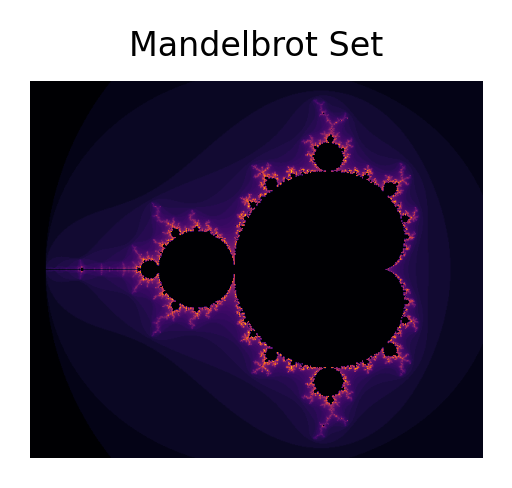

In [4]:
# Parameters
xmin, xmax = -2.1, 0.9
ymin, ymax = -1.25, 1.25
xpixels, ypixels = 600, 500
maxiter = 100

# Running and plotting result
res = mandel(xmin, xmax, ymin, ymax, xpixels, ypixels, maxiter)
plot_res(res)

Here we can visualize the **Mandelbrot set**! The inner points, in black ($res = 0$), are those who belong to the set. The outer points are colored according to the number of iterations before $|z_n| > 2$. The boundary of the set looks very *complicated*, or *chaotic*. Actually it has been demonstrated in *(Shishikura, 1991)* that the boundary of the Mandelbrot set is a 2 dimension object! A lot of mathematical questions about the set are still open to date.

The drawing is as expected, but it seems to take seconds to run. We will run it 30 times (3 runs of 10) the algorithm to estimate accuretaly its runtime.

In [5]:
# Measuring computation time
%timeit -n 10 -r 3 mandel(xmin, xmax, ymin, ymax, xpixels, ypixels, maxiter)

3.16 s ± 12.9 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


With given parameters, it runs in approximately **3 seconds** (of course, depending on the hardware you run it on). It is a bit slow, in particular if we want to run it mutliple time or with more pixels and more iterations! We will try to speed up things using **GPU computing**.

# Part 2: Computation on GPU with CUDA
<a id="part2"></a>
***
It is possible to accelerate our algorithm using the GPU instead of the CPU. We will use the **CUDA toolkit** to execute code on the GPU. Here you can find [an introduction to CUDA](https://developer.nvidia.com/blog/even-easier-introduction-cuda/).

In this notebook, we will use the [CUDA jit toolkit by Numba](http://numba.pydata.org/numba-doc/0.13/CUDAJit.html). You can find a very clear tutorial on [CUDA Programming with Numba](https://nyu-cds.github.io/python-numba/05-cuda/) by the New York University. This toolkit is a high level point of entry to GPU computing which allows us to execute Python functions on the CUDA hardware. This will save us the pain of rewriting our Python code in CUDA!

Of course, a GPU compatible with CUDA is required to execute the code below. The first step is to import the `numba.cuda` module:

In [6]:
from numba import cuda

## How to execute Python function on CUDA

In order to execute our function on CUDA, we need to make it a **CUDA kernel** and set the dimension of the grid on which the kernel will run (in parallel!).

Keep in mind that you can further optimize the runtime by playing with the grid structure (grid dimension, number of blocks per grid and of threads per blocks), and the optimal structure depends of the GPU device you are using. To keep the code short and clear we will use a **1D-grid with `xpixels` blocks of `ypixels` threads**.

We need to make some minor adjustments to our code:
- add the `@cuda.jit` decorator before our function definition to make it a CUDA kernel
- we don't need to loop through each pixel, since it is handled by the grid structure
- we get the `x` and `y` indexes with respectively `cuda.blockIdx.x` (ID of current block) and `cuda.threadIdx.x` (ID of current thread)
- the kernel can not return any output, but NumPy arrays that are supplied as arguments to it are automatically transferred between the CPU and the GPU. We will use this feature to modify the `res` array.
- in the kernel call, we need to set the number of blocks (`xpixels`) and the number of threads per blocks (`ypixels`)

but everything else is identical!

In [7]:
@cuda.jit
def mandel_gpu(res, xmin, xmax, ymin, ymax, maxiter):
    x = cuda.blockIdx.x
    y = cuda.threadIdx.x
    
    # Mapping pixel to C
    creal = xmin + x / res.shape[0] * (xmax - xmin)
    cim = ymin + y / res.shape[1] * (ymax - ymin)
    
    # Initialisation of C and Z
    c = complex(creal, cim)
    z = complex(0, 0)
    
    # Mandelbrot iteration
    for n in range(maxiter):
        z = z*z+c
        # If unbounded: save number of iteration
        if z.real*z.real + z.imag*z.imag > 4.0:
            res[x,y] = n
            break
        # Otherwise: leave it to 0

Let's try with the parameters used in part 1, for the sake of comparison:

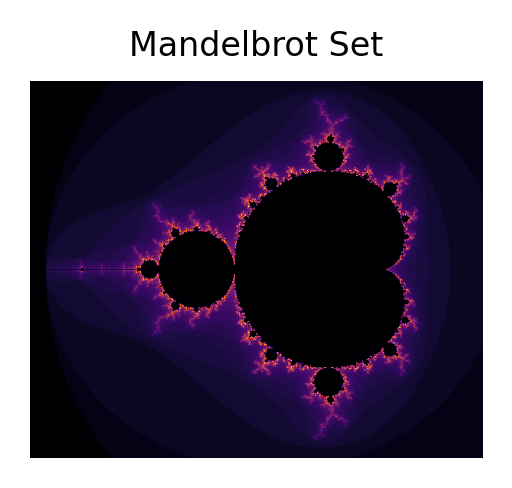

In [8]:
# Parameters
xmin, xmax = -2.1, 0.9
ymin, ymax = -1.25, 1.25
xpixels, ypixels = 600, 500
maxiter = 100
res = np.zeros((xpixels, ypixels))

# Running and plotting result
mandel_gpu[xpixels, ypixels](res, xmin, xmax, ymin, ymax, maxiter)
plot_res(res)

The picture is identical to the above one, so our algorithm ran as expected! Now let's check the runtime.

In [9]:
# Measuring computation time
%timeit -n 10 -r 3 mandel_gpu[xpixels, ypixels](res, xmin, xmax, ymin, ymax, maxiter)

2.17 ms ± 158 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


The speedup is **huge**: runtime is reduced by **more than 1000x**!

Now that we have a very fast implementation, we can run it with more pixels and iterations.

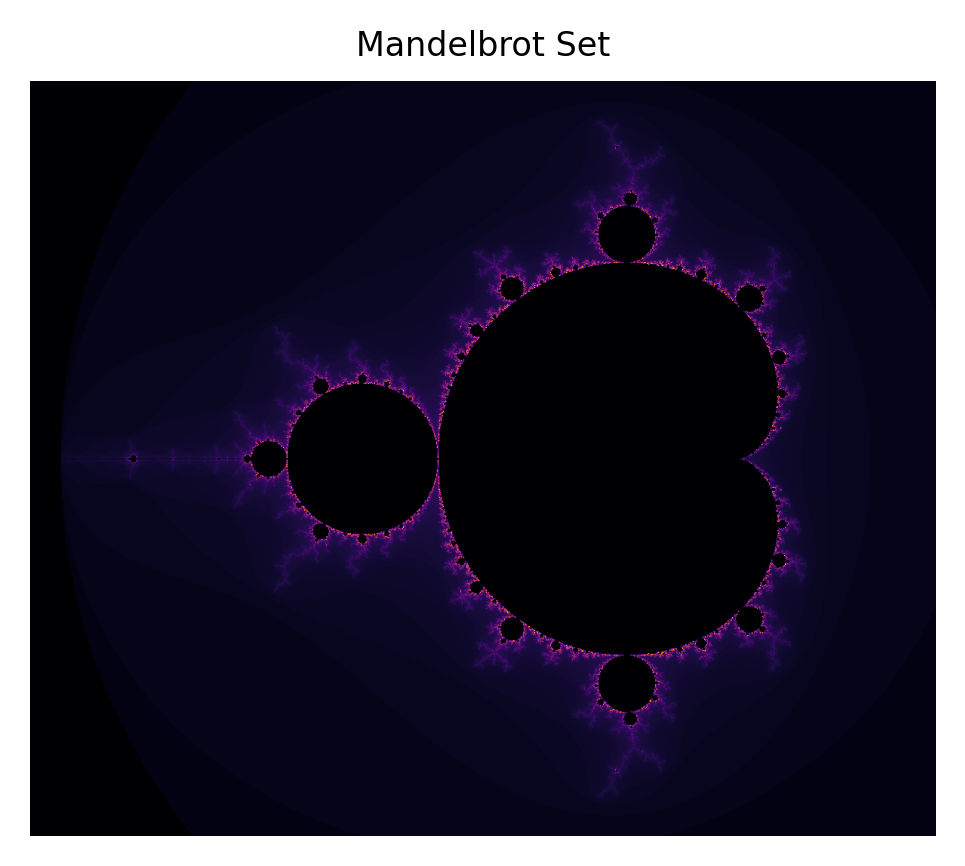

In [10]:
# Parameters
xpixels, ypixels = 1200, 1000
maxiter = 1000
res = np.zeros((xpixels, ypixels))

# Running and plotting result
mandel_gpu[xpixels, ypixels](res, xmin, xmax, ymin, ymax, maxiter)
plot_res(res, powern = 0.5)

The image quality is much better, and runtime still very fast.

We will now plot some other places of the Mandelbrot Set, by changing the frame parameters, and playing with the colormaps.

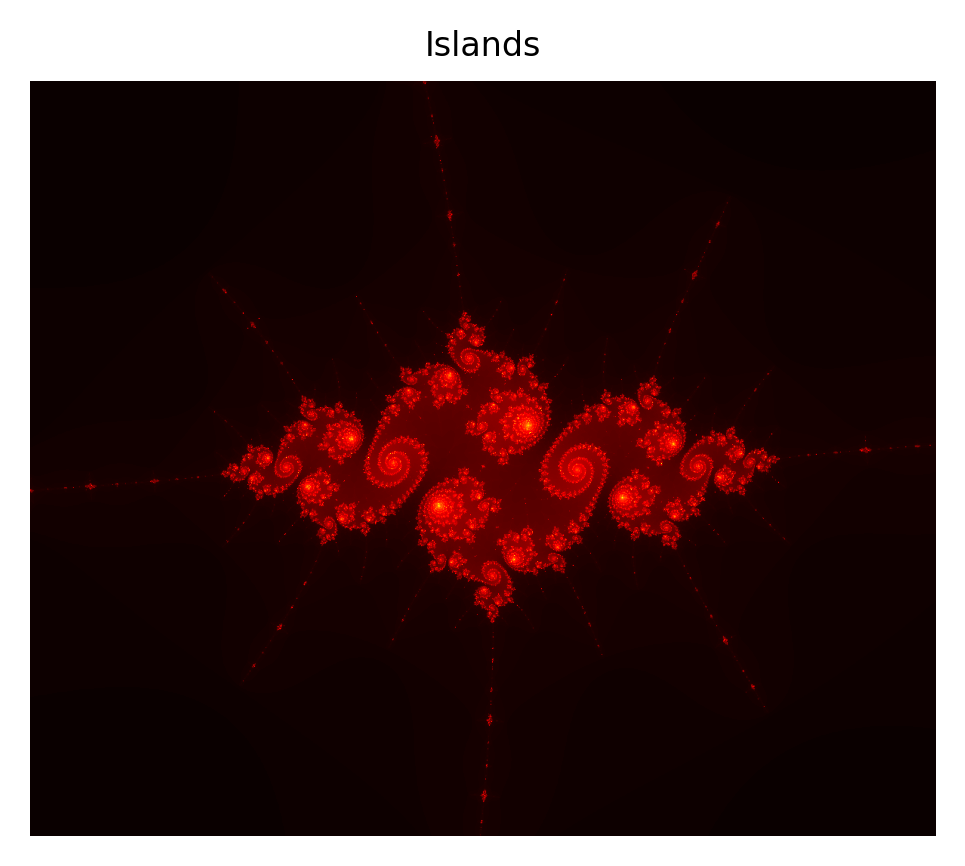

In [11]:
xmin, xmax = -1.7687782, -1.7687794
ymin, ymax = -0.0017384, -0.0017394
# Some deeper places need more iterations
maxiter = 1e4
res = np.zeros((xpixels, ypixels))

mandel_gpu[xpixels, ypixels](res, xmin, xmax, ymin, ymax, maxiter)
plot_res(res, 'Islands', cmap='hot')

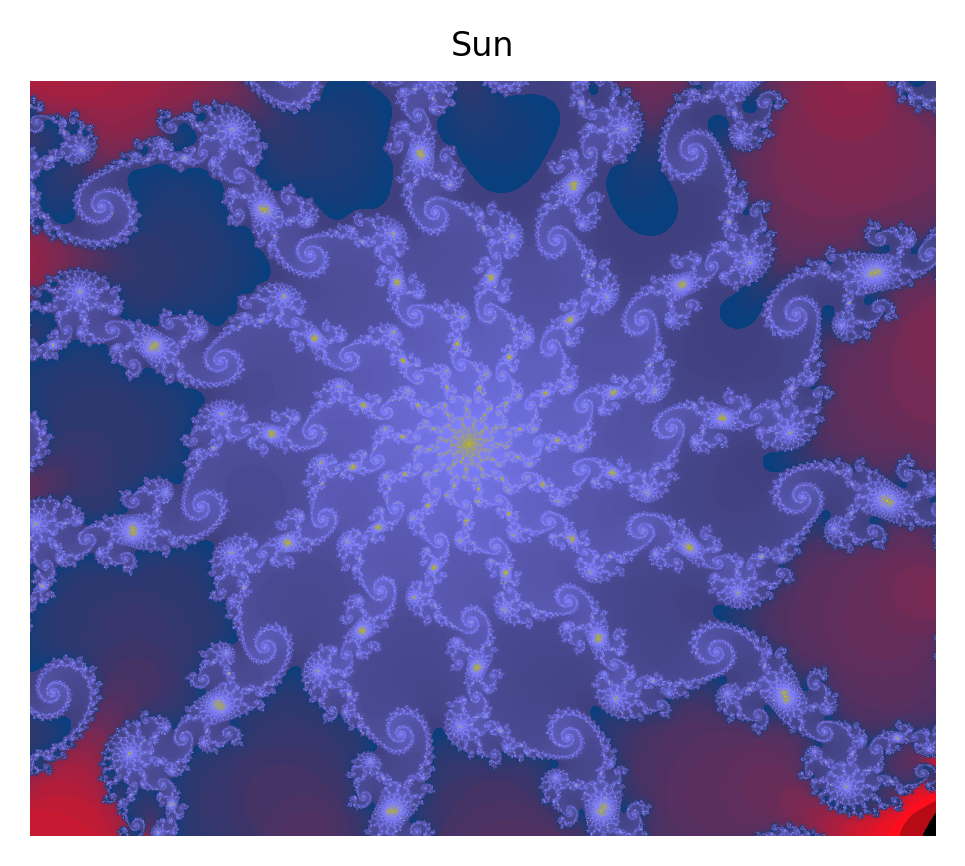

In [12]:
xmin, xmax = -0.776605, -0.776580
ymin, ymax = -0.136651, -0.136630
res = np.zeros((xpixels, ypixels))

mandel_gpu[xpixels, ypixels](res, xmin, xmax, ymin, ymax, maxiter)
plot_res(res, 'Sun', cmap='gist_stern', powern = 0.5)

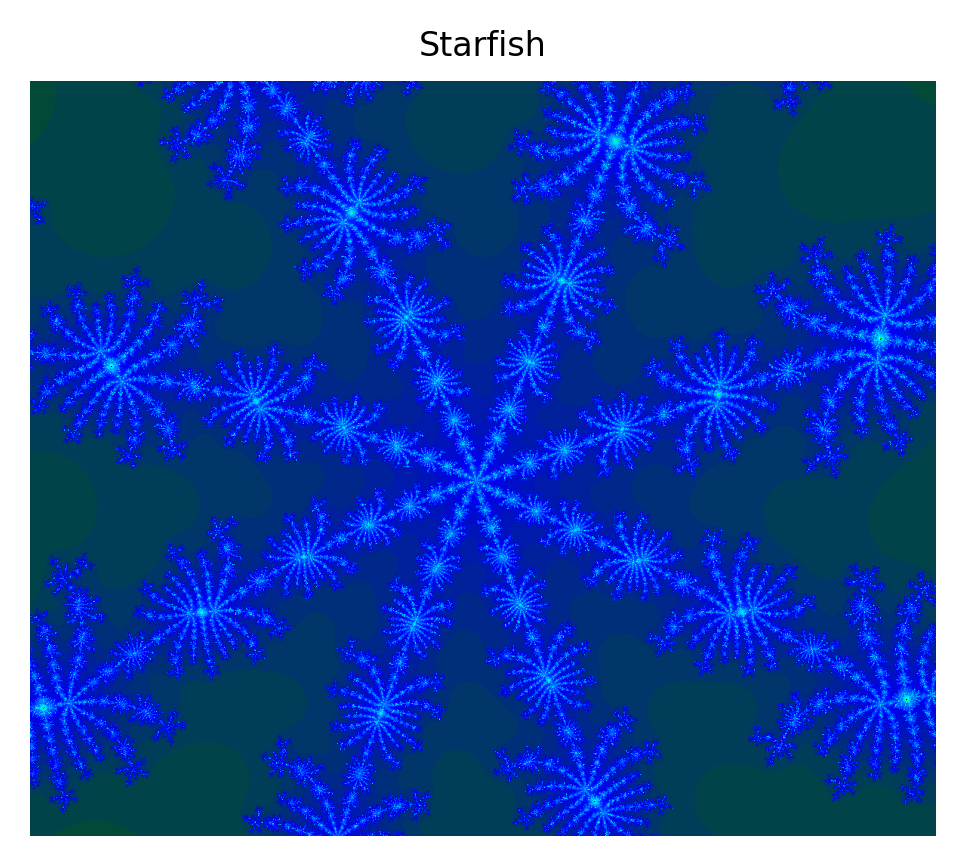

In [13]:
xmin, xmax = -0.3754, -0.3725
ymin, ymax = 0.6585, 0.6609
res = np.zeros((xpixels, ypixels))

mandel_gpu[xpixels, ypixels](res, xmin, xmax, ymin, ymax, maxiter)
plot_res(res, 'Starfish', cmap='gist_ncar')

To dive further in the subject, here are some links from where I draw inspiration:
- [CUDA Programming with Numba](https://nyu-cds.github.io/python-numba/05-cuda/) by 
the NYU Center for Data Science
- [GPU accelerated Mandelbrot Set in Python](https://www.researchgate.net/publication/339781069_GPU_Accelerated_Mandelbrot_Set_in_Python) 
- [How To Quickly Compute The Mandelbrot Set In Python](https://gist.github.com/jfpuget/60e07a82dece69b011bb)  
- [Numba + CUDA Mandelbrot](https://www.kaggle.com/landlord/numba-cuda-mandelbrot)
- [Mandelbrot Set Explorer](https://mandel.gart.nz/) 

### **Do not hesitate to like, comment, and fork the code to try it yourself!**